In [ ]:
!pip install fsspec==2024.10.0
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_scheduler
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load the IMDb dataset
dataset = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
def collate_fn(batch):
    return {
        'input_ids': torch.tensor([b['input_ids'] for b in batch]),
        'attention_mask': torch.tensor([b['attention_mask'] for b in batch]),
        'labels': torch.tensor([b['label'] for b in batch])
    }

In [ ]:
train_loader = DataLoader(encoded_dataset['train'], batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(encoded_dataset['test'], batch_size=8, shuffle=False, collate_fn=collate_fn)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Fine-tuning
epochs = 3
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = {key: val.to(device) for key, val in batch.items()}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.3638
Epoch 2, Loss: 0.1878
Epoch 3, Loss: 0.0790


In [ ]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = inputs['labels'].cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels)

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(true_labels, predictions))

Accuracy: 0.9277
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     12500
           1       0.92      0.93      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



In [ ]:
def get_attention_weights(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions
    return attentions

def get_prediction_label(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    return prediction



In [ ]:
def visualize_attention(attention_weights, input_text, tokenizer):
    # Decode tokens
    tokens = tokenizer.tokenize(input_text)
    tokens = ["[CLS]"] + tokens[:min(len(tokens), 510)] + ["[SEP]"]

    # Use the last layer's attention weights
    last_layer_attention = attention_weights[-1]  # Shape: (1, num_heads, seq_len, seq_len)
    avg_attention = last_layer_attention.mean(dim=1).squeeze(0).detach().cpu().numpy()  # Average over heads and detach

    # Plot attention heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_attention[:len(tokens), :len(tokens)], xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title("Attention Heatmap")
    plt.xlabel("Attention to Tokens")
    plt.ylabel("Source Tokens")
    plt.show()

In [ ]:
sample_text = "The movie was absolutely fantastic!"
attention_weights = get_attention_weights(sample_text)
print(f"Attention weights for sample text: {sample_text}")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Attention weights for sample text: The movie was absolutely fantastic!


In [ ]:
prediction_label = get_prediction_label(sample_text)
print(f"Prediction label for sample text: {prediction_label}")

Prediction label for sample text: 1


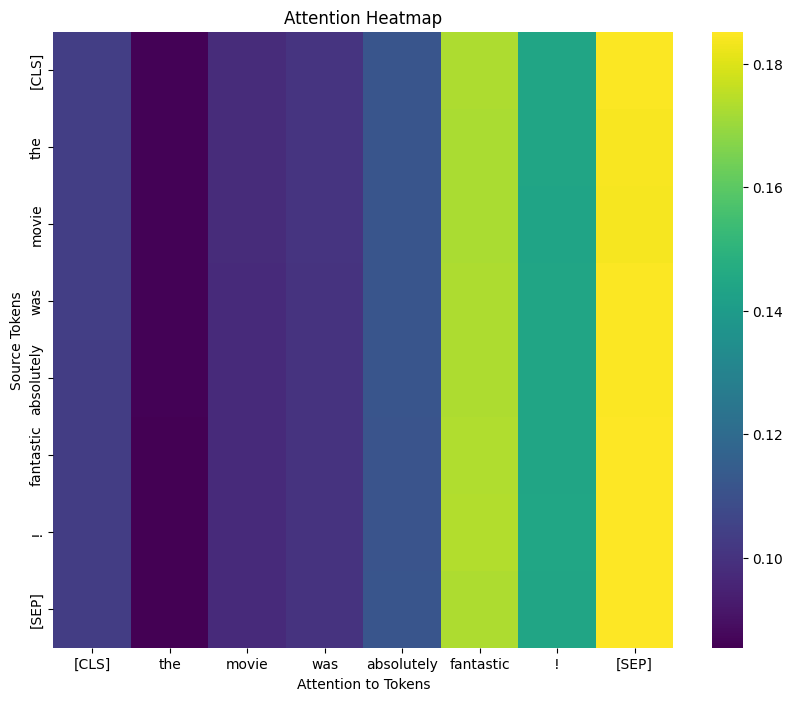

In [ ]:

# Visualize attention for the sample text
visualize_attention(attention_weights, sample_text, tokenizer)

In [ ]:
def save_model(model, tokenizer, save_path="bert_sentiment_model"):
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"Model and tokenizer saved to {save_path}")

def load_model(save_path="bert_sentiment_model"):
    model = BertForSequenceClassification.from_pretrained(save_path)
    tokenizer = BertTokenizer.from_pretrained(save_path)
    print(f"Model and tokenizer loaded from {save_path}")
    return model, tokenizer



In [ ]:
# Save the model
save_model(model, tokenizer)



In [ ]:
# Example: Load the model
loaded_model, loaded_tokenizer = load_model()